In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from PIL.Image import LANCZOS
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Check Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define Hyper-parameters 
num_epochs = 10
batch_size = 100
learning_rate = 0.001

In [ ]:
# Mnist dataset
train_dataset = datasets.MNIST(root='../../data', 
                                           train=True, 
                                           transform=transforms.Compose([
                                                    transforms.Resize(64, interpolation=LANCZOS),
                                                    transforms.ToTensor()
                                           ]),
                                           download=True)
  


test_dataset = datasets.MNIST(root='../../data', 
                                            train=False, 
                                            transform=transforms.Compose([
                                                      transforms.Resize(64, interpolation=LANCZOS),
                                                      transforms.ToTensor()
                                            ]),
                                            download=True)

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)
train_dataset.data.shape


Extracting ../../data/MNIST/raw/train-images-idx3-ubyte.gz to ../../data/MNIST/raw


Extracting ../../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../../data/MNIST/raw


Extracting ../../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/MNIST/raw




Extracting ../../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


torch.Size([60000, 28, 28])

In [ ]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def forward(self, input, size=32*32):
        return input.view(input.size(0), size, 1, 1)

class VAE(nn.Module):
    def __init__(self, image_channels=1, h_dim=1024, z_dim=32):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            #(batch,1,64,64)
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            #(batch,32,31,31)
            nn.ReLU(),
            nn.Dropout2d(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            #(batch,64,14,14)
            nn.ReLU(),
            nn.Dropout2d(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            #(batch,128,6,6)
            nn.ReLU(),
            nn.Dropout2d(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            #(batch,256,2,2)
            nn.ReLU(),
            nn.Dropout2d(),
            Flatten(),
            # (batch,1024)
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)#32
        self.fc2 = nn.Linear(h_dim, z_dim)#32
        #self.fc3 = nn.Linear(z_dim, h_dim)#1024
        
        self.decoder = nn.Sequential(
            #(batch,32)
            nn.Linear(32, 1024),
            #(batch,1024)
            UnFlatten(),
            #(batch,1024,1,1)
            nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2),
            #(batch,128,5,5)
            nn.ReLU(),
            nn.Dropout2d(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            #(batch,64,13,13)
            nn.ReLU(),
            nn.Dropout2d(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
            #(batch,32,30,30)
            nn.ReLU(),
            nn.Dropout2d(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
            #(batch,1,64,64)
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        #(batch,32)

        # return torch.normal(mu, std)
        # [*] is used as size can vary
        esp = torch.randn(*mu.size()).to(device)
        #(batch,32)

        z = mu + std * esp
        #(batch,32)
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        #(batch,32),(batch,32)

        z = self.reparameterize(mu, logvar)
        #(batch,32)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        #(batch,1024)

        z, mu, logvar = self.bottleneck(h)
        #(all are (batch,32))

        return z, mu, logvar

    def decode(self, z):
        #z = self.fc3(z)
        #(batch,1024)

        z = self.decoder(z)
        #(batch,1,64,64)

        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        #(all are (batch,32))

        z = self.decode(z)
        #(batch,1,64,64)

        return z, mu, logvar
        #(batch,1,64,64),(batch,32),(batch,32)

def binary_cross_entropy(x, y):

    #loss1 = -((x+0.001).log() * y + (1 - x+0.001).log() * (1 - y))
    loss1 = nn.BCELoss(reduction='sum')
    return loss1(x,y)


def loss_function(recon_x, x, mu, logvar):
    BCE = binary_cross_entropy(recon_x, x)

    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


In [ ]:
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)  

In [ ]:
for epoch in range(num_epochs):

    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


Train Epoch: 0 [0/60000 (0%)]	Loss: 609.727578
Train Epoch: 0 [1000/60000 (2%)]	Loss: 596.866953
Train Epoch: 0 [2000/60000 (3%)]	Loss: 602.101484
Train Epoch: 0 [3000/60000 (5%)]	Loss: 586.924102
Train Epoch: 0 [4000/60000 (7%)]	Loss: 594.598281
Train Epoch: 0 [5000/60000 (8%)]	Loss: 593.577930
Train Epoch: 0 [6000/60000 (10%)]	Loss: 598.562344
Train Epoch: 0 [7000/60000 (12%)]	Loss: 599.785430
Train Epoch: 0 [8000/60000 (13%)]	Loss: 534.917891
Train Epoch: 0 [9000/60000 (15%)]	Loss: 591.544453
Train Epoch: 0 [10000/60000 (17%)]	Loss: 581.744570
Train Epoch: 0 [11000/60000 (18%)]	Loss: 569.493906
Train Epoch: 0 [12000/60000 (20%)]	Loss: 590.934141
Train Epoch: 0 [13000/60000 (22%)]	Loss: 568.504453
Train Epoch: 0 [14000/60000 (23%)]	Loss: 579.984180
Train Epoch: 0 [15000/60000 (25%)]	Loss: 583.405859
Train Epoch: 0 [16000/60000 (27%)]	Loss: 578.391484
Train Epoch: 0 [17000/60000 (28%)]	Loss: 594.861484
Train Epoch: 0 [18000/60000 (30%)]	Loss: 569.081094
Train Epoch: 0 [19000/60000 (32

In [ ]:
# Train the model
a_factor=0
total_step = len(train_loader)
for epoch in range(num_epochs):
    if(epoch>8):
      a_factor+=0.01
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        z, mu, logvar = model(images)
        loss = loss_function(z,images,mu,logvar,a_factor)
        BCE_loss = binary_cross_entropy(z,images)
        # Backprpagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], KLD_Loss: {:.4f}, BCE_Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()-BCE_loss.item(),BCE_loss.item()))


Epoch [1/10], Step [100/600], KLD_Loss: 0.0000, BCE_Loss: 114638.8438
Epoch [1/10], Step [200/600], KLD_Loss: 0.0000, BCE_Loss: 89396.6875
Epoch [1/10], Step [300/600], KLD_Loss: 0.0000, BCE_Loss: 73742.7266
Epoch [1/10], Step [400/600], KLD_Loss: 0.0000, BCE_Loss: 68250.7344
Epoch [1/10], Step [500/600], KLD_Loss: 0.0000, BCE_Loss: 62816.2031
Epoch [1/10], Step [600/600], KLD_Loss: 0.0000, BCE_Loss: 62518.7500
Epoch [2/10], Step [100/600], KLD_Loss: 0.0000, BCE_Loss: 59316.0000
Epoch [2/10], Step [200/600], KLD_Loss: 0.0000, BCE_Loss: 58599.4648
Epoch [2/10], Step [300/600], KLD_Loss: 0.0000, BCE_Loss: 58305.1914
Epoch [2/10], Step [400/600], KLD_Loss: 0.0000, BCE_Loss: 55218.5742
Epoch [2/10], Step [500/600], KLD_Loss: 0.0000, BCE_Loss: 57216.1641
Epoch [2/10], Step [600/600], KLD_Loss: 0.0000, BCE_Loss: 58685.1094
Epoch [3/10], Step [100/600], KLD_Loss: 0.0000, BCE_Loss: 54340.5234
Epoch [3/10], Step [200/600], KLD_Loss: 0.0000, BCE_Loss: 55269.6641
Epoch [3/10], Step [300/600], KLD

In [ ]:
z=torch.randn((25,32)).to(device)
rec=model.decoder(z).to('cpu').detach()
rec[0].shape

torch.Size([1, 64, 64])

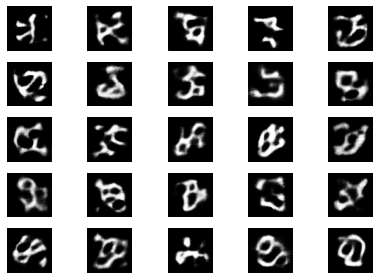

In [ ]:
cnt=0

for i in range(5):
  for j in range(5):
    cnt+=1
    plt.subplot(5,5,cnt)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.imshow(np.reshape(rec[cnt-1], [64, 64]), cmap='gray')
    plt.axis("off")
plt.tight_layout()    
plt.show()